In [93]:
import pandas as pd
from data_clean import DataClean
from add_public_data import PublicData
from create_lag import CreateLag
from cust_seg import CustSeg
from split import Split
from std_scale import StdScale
from pred_model import PredModel
from forcast import Forcast
from model_functions import plot_rmse
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')
from model_functions import model_clusters, plot_rmse, forc_model_test
import numpy as np
from matplotlib import rc
import matplotlib.pyplot as plt

font = {'size': 20}
rc('font', **font)
plt.style.use('seaborn-dark-palette')
pd.set_option('max_columns',500)

In [2]:
def run_cust_seg(df, num_clusts=4, plot_clusts=False, plot_sil=False):
    print('Segmenting Customers...')
    pub = PublicData(include_crime=False, remove_nan_rows=True)
    df_public = pub.fit_transform(df)

    cs = CustSeg(clusters=num_clusts, plot_clusts=plot_clusts, plot_sil=plot_sil)
    cust_table = cs.fit_transform(df_public)
    return cust_table

In [5]:
def run_pred_model(df, non_feature_cols, cust_table, model, grid_search=True, param_grid=None, user_model_list=None, rmse_plot=False):
    print('Running Prediction Model...')
    print('Creating lag variables...')
    cl = CreateLag(lag_periods=2, col_filters=['address1', 'item_category'], 
                   date_col='visit_date', lag_vars=['qty_shrink_per_day', 'shrink_value_per_day'], 
                   col_name_suf='_by_cat', remove_nan_rows=True)
    df_lag = cl.fit_transform(df)

    print('Adding public data...')
    pub = PublicData(include_crime=False, remove_nan_rows=True)
    df_public = pub.fit_transform(df_lag)

    print('Splitting...')
    spl = Split(non_feature_cols, target_col='shrink_value_per_day', split_by_time=False)
    spl.fit(df_public, cust_table)
    X, y, X_train, X_test, y_train, y_test = spl.transform(df_public, cust_table)

    print('Standardizing...')
    ss = StdScale(std=True, scale=True)
    X_train_ss = ss.fit_transform(X_train)
    X_test_ss = ss.fit_transform(X_test)

    print('Fitting model...')
    pm = PredModel(model, grid_search=grid_search, param_grid=param_grid, user_model_list=user_model_list)
    fitted_models = pm.fit(X_train_ss, y_train)

    if rmse_plot:
        print('Plotting...')
        pred_col_mask = (X_train_ss.dtypes == int) | (X_train_ss.dtypes == np.float64) | (X_train_ss.dtypes == np.uint8)
        pred_cols = X_train_ss.columns[pred_col_mask]
        cluster_rmse, naive_rmse = model_clusters(fitted_models, X_test=X_test_ss, X_test_ns=X_test, naive_col='shrink_value_per_day_lag1_by_cat', col_mask=pred_cols, y_test=y_test)
        plot_rmse(cluster_rmse, naive_rmse, num_clusters=len(X.cluster.unique()), 
          title='Predicting Next Visit Shrink Value')
    return pm, X_train_ss, y_train

In [4]:
def run_forc_model(df, non_feature_cols, cust_table, model, params, rmse_plot=False):
    print('Running Forcast Model...')
    cl = CreateLag(lag_periods=2, col_filters=['address1'], 
                   date_col='visit_date', lag_vars=['qty_shrink_per_day', 'shrink_value_per_day'], 
                   col_name_suf='_by_store', remove_nan_rows=True)
    df_lag = cl.fit_transform(df)

    pub = PublicData(include_crime=False, remove_nan_rows=True)
    df_public = pub.fit_transform(df_lag)

    split_date = pd.to_datetime('12/1/2017')
    spl = Split(non_feature_cols, target_col='shrink_value_per_day', split_by_time=True, date_col='visit_date', split_date=split_date)
    spl.fit(df_public, cust_table)
    X, y, X_train, X_test, y_train, y_test = spl.transform(df_public, cust_table)

    ss = StdScale(std=True, scale=True)
    X_ss = ss.fit_transform(X)
    X_train_ss = ss.fit_transform(X_train)
    X_test_ss = ss.fit_transform(X_test)

    forc_cols = ['FD_ratio', 'LAPOP1_10', 'POP2010', 'dens_sq_mile', 'unemp_rate', 'qty_POG_limit', 'unit_price', 'shrink_value_per_day_lag1_by_store', 'shrink_value_per_day_lag2_by_store' ]
    for col in X_ss.columns:
        if 'customer_id' in col:
            forc_cols.append(col)
    fc = Forcast(model, params, forc_cols, num_periods=4)
    fitted_models = fc.fit(X_ss, y)
    if rmse_plot:
        # plot forcast against current training data
        cluster_rmse, naive_rmse = model_clusters(fitted_models, X_test=X_test_ss, X_test_ns=X_test, naive_col='shrink_value_per_day_lag1_by_store', col_mask=forc_cols, y_test=y_test)
        plot_rmse(cluster_rmse, naive_rmse, num_clusters=len(X.cluster.unique()), 
          title='Training Forcast')
        # plot forcast against future data
        forc_model_test(X_test, y_test, fitted_models, col_mask=forc_cols)
    return fc.forcast(cust_table)

In [2]:
print('Reading and cleaning data...')
df = pd.read_pickle('../data/SRP/raw_subset_300k.pkl')
dc = DataClean(remove_nan_rows=True)
df = dc.fit_transform(df)

Reading and cleaning data...


In [15]:
df.head()

,visit_date,prev_visit_date,prev_item_move_date,ship_id,address1,sales_rep_id,item_id,old_item_id,item_UPC,old_item_UPC,item_description,qty_POG_limit,qty_n,qty_f,qty_o,qty_d,qty_delivery,qty_sales,unit_price,qty_prev_end_inventory,qty_out,qty_start_inventory,qty_end_inventory,qty_inv_out,qty_ex_del,qty_shrink,qty_shrink_out,qty_shrink_ex_del,sales_value,shrink_value,shrink_to_sales_value_pct,shrink_value_out,shrink_to_sales_value_pct_out,shrink_value_ex_del,shrink_to_sales_value_pct_ex_del,ship_list_pk,sales_rep_id_2,address2,city,state,list_header_id,last_edit_date,creation_date,visit_date_int,prev_visit_date_int,prev_item_move_date_int,last_edit_date_int,creation_date_int,zip_code,qty_shrink_per_day,shrink_value_per_day,item_category_8,item_category_10,item_category_16,item_category_19,item_category_26,item_category_31,item_category_38,item_category_41,item_category_43,item_category_44,item_category_46,item_category_58,item_category_62,item_category_77,item_category_79,item_category_90,customer_id_2139,customer_id_1635139,customer_id_1903139,customer_id_2331150,customer_id_2741156,customer_id_2773156,customer_id_2782156,customer_id_2956160,customer_id_2977160,customer_id_3083182,customer_id_3088198,customer_id_3088201,customer_id_3089336,customer_id_3093327,customer_id_3093329,customer_id_3097348,item_category,customer_id
3414634,2018-01-04,2017-12-07,2017-10-26,164431,7 ELEVEN SBT PROGRAM #39186,100197113,2973338,2973338,5254860446,5254860446,0711 STEREO EARBUDS W/MIC (BLACK),6,1,0,0,0,1,2,4.90,6.0,1,5,6,2.0,1.0,0.0,-1,-1.0,9.80,0.0,0.0,2.90,29.591837,-4.9,-50.0,152282,100197113,4200 WINTR GRDEN VINELAND,WINTER GARDEN,FL,4513311,2017-02-03 23:31:49,2016-08-23 07:37:37,1.515049e+09,1.512630e+09,1.508998e+09,1.486190e+09,1.471959e+09,34787,0.000000,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,16,2773156
4548441,2017-12-21,2017-11-30,2017-11-30,163005,7 ELEVEN SBT PROGRAM #35316,100304126,2378135,2378135,60870716205,60870716205,VL CAR CHRG W/DUAL USB 2.1A,20,11,0,0,0,0,5,2.45,20.0,11,9,20,11.0,11.0,6.0,6,6.0,12.25,14.7,120.0,21.95,179.183673,14.7,120.0,170566,100304126,2830 HANOVER ST,BALTIMORE,MD,4513311,2017-08-03 09:00:37,2017-02-05 10:00:32,1.513840e+09,1.512025e+09,1.512025e+09,1.501772e+09,1.486314e+09,21225,0.285714,0.7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,16,2773156
3106537,2017-12-06,2017-11-15,2017-10-25,157884,7 ELEVEN SBT PROGRAM #11173,100282114,2450157,2450157,5254856843,5254856843,0711 SUCTION MOUNT SMARTPHONE HOLDER,2,0,0,1,0,0,1,4.20,2.0,0,3,2,-1.0,-1.0,-2.0,-1,-2.0,4.20,-8.4,-200.0,-1.00,-23.809524,-8.4,-200.0,156925,100282114,475 MERRICK RD,OCEANSIDE,NY,4513311,2016-09-23 09:01:08,2016-08-23 07:37:37,1.512544e+09,1.510729e+09,1.508911e+09,1.474643e+09,1.471959e+09,11572,-0.095238,-0.4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,16,2773156
3660096,2017-06-03,2017-05-18,2017-05-18,119409,SPEEDWAY #8034,100063114,33,33,60870710034,60870710034,PUGS THIN LEASH,4,2,0,0,0,0,2,1.34,4.0,2,2,4,2.0,2.0,0.0,0,0.0,2.68,0.0,0.0,0.68,25.373134,0.0,0.0,139192,100063114,1005 S PERU ST,CICERO,IN,3386280,2016-08-23 07:37:38,2016-08-23 07:37:37,1.496470e+09,1.495087e+09,1.495087e+09,1.471959e+09,1.471959e+09,46034,0.000000,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,10,2331150
3172594,2018-01-04,2017-12-07,2017-11-29,68030,MAVERIK #388,100295126,2279857,889105,60870712447,60870711003,T8 TREND SG 11.99,2,1,0,0,0,0,-1,5.64,0.0,1,1,2,-1.0,-1.0,0.0,2,0.0,-5.64,0.0,0.0,6.64,-117.730496,0.0,0.0,128902,100295126,901 PENROD ROAD,SHOW LOW,AZ,4908309,2017-04-19 09:00:39,2016-08-23 07:37:37,1.515049e+09,1.512630e+09,1.511939e+09,1.492614e+09,1.471959e+09,85901,0.000000,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,2139


In [4]:
# customer table and segmentation
load_table = True
if load_table:
    try:
        cust_table = pd.read_pickle('../data/SRP/cust_table_out.pkl')
    except:
        cust_table = run_cust_seg(df, num_clusts=4, plot_clusts=True, plot_sil=False)
else:
    cust_table = run_cust_seg(df, num_clusts=4, plot_clusts=True, plot_sil=False)
print(cust_table.groupby('cluster').mean())

         qty_shrink_per_day  shrink_value_per_day       POP2010  FD_ratio  \
cluster                                                                     
0                  0.147241              0.774161  5.906176e+05  0.236426   
1                  0.020771              0.111971  7.815510e+06  0.059123   
2                  0.017033              0.091435  1.285113e+06  0.143422   
3                  0.021676              0.100313  5.773403e+05  0.318678   

         unemp_rate  dens_sq_mile  avg_UPC_per_visit  days_between_visits  
cluster                                                                    
0          0.087801   2100.350662           3.141296            16.844484  
1          0.081551  19348.340139           2.511752            35.442338  
2          0.085955   4178.674517           2.662191            29.806585  
3          0.074561   1885.247147           2.748275            27.953508  


In [29]:
# build models
non_feature_cols = ['shrink_value', 'shrink_to_sales_value_pct', 'shrink_value_out', 'shrink_to_sales_value_pct_out', 'shrink_value_ex_del', 'shrink_to_sales_value_pct_ex_del', 'qty_inv_out', 'qty_shrink', 'qty_shrink_ex_del', 'qty_shrink_out', 'qty_end_inventory', 'qty_f', 'qty_out', 'qty_ex_del', 'qty_n', 'qty_delivery', 'qty_o', 'qty_d', 'qty_shrink_per_day', 'shrink_value_per_day', 'qty_start_inventory']
use_MLP=True
if use_MLP:
    model = MLPRegressor()
    params = {'alpha': [0.0001, 0.001, 0.01, 1], 'hidden_layer_sizes': [(300,), (100,), (50,50), (50,50,50)], 'learning_rate_init': [0.01, 0.001, 0.0001], 'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['adam'],  'max_iter': [3000]}
    params_basic = {'hidden_layer_sizes': [(100,)], 'learning_rate_init': [0.001], 
          'activation': ['relu'], 'solver': ['adam'],  'max_iter': [100]}
else:
    model = RandomForestRegressor()
    params = {'n_estimators': [20, 100, 300], 'max_features': [3, 6, 9, 12, 15], 'max_depth': [None, 10, 30], 'min_samples_leaf': [1, 5, 10], 'max_leaf_nodes': [None, 20, 100],  'n_jobs': [-1]}
    params_basic = {'n_estimators': [10], 'n_jobs': [-1]}

# daily prediction model
#pm, X_train, y_train = run_pred_model(df, non_feature_cols, cust_table, model, params, rmse_plot=True)

# opt_params: cluster:  1
# {'activation': 'identity', 'alpha': 0.001, 'hidden_layer_sizes': (300,), 'learning_rate_init': 0.0001, 'max_iter': 3000, 'solver': 'adam'}

# cluster:  2
# {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.0001, 'max_iter': 3000, 'solver': 'adam'}

# cluster:  3
# {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (300,), 'learning_rate_init': 0.0001, 'max_iter': 3000, 'solver': 'adam'}

# cluster:  4
# {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate_init': 0.01, 'max_iter': 3000, 'solver': 'adam'}

# forecast model
#cust_table_agg = run_forc_model(df, non_feature_cols, cust_table, model, params, rmse_plot=True)

In [7]:
print('Creating lag variables...')
cl = CreateLag(lag_periods=2, col_filters=['address1', 'item_category'], 
               date_col='visit_date', lag_vars=['qty_shrink_per_day', 'shrink_value_per_day'], 
               col_name_suf='_by_cat', remove_nan_rows=True)
df_lag = cl.fit_transform(df)

print('Adding public data...')
pub = PublicData(include_crime=False, remove_nan_rows=True)
df_public = pub.fit_transform(df_lag)

Creating lag variables...
Adding public data...


In [88]:
print('Splitting...')
spl = Split(non_feature_cols, target_col='qty_shrink_per_day', split_by_time=False)
spl.fit(df_public, cust_table)
X, y, X_train, X_test, y_train, y_test = spl.transform(df_public, cust_table)

print('Standardizing...')
ss = StdScale(std=True, scale=True)
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.fit_transform(X_test)

Splitting...
Standardizing...


In [125]:
model_0 = MLPRegressor(activation='tanh', alpha=0.001, hidden_layer_sizes=(50, 50, 50), 
                       learning_rate_init=0.0001, max_iter=3000, solver='adam')
model_1 = MLPRegressor(activation='relu', alpha=0.001, hidden_layer_sizes=(300,), 
                       learning_rate_init=0.001, max_iter=3000, solver='adam')
model_2 = MLPRegressor(activation='tanh', alpha=0.01, hidden_layer_sizes=(50, 50), 
                       learning_rate_init=0.0001, max_iter=3000, solver='adam')
model_3 = MLPRegressor(activation='tanh', alpha=0.001, hidden_layer_sizes=(50, 50), 
                       learning_rate_init=0.0001, max_iter=3000, solver='adam')
mlp_list = [model_0, model_1, model_2, model_3]

In [126]:
model_0 = RandomForestRegressor(max_depth=30, max_features=15, max_leaf_nodes=None, min_samples_leaf=5, n_estimators=100, n_jobs=-1)
model_1 = RandomForestRegressor(max_depth=30, max_features=15, max_leaf_nodes=100, min_samples_leaf=5, n_estimators=20, n_jobs=-1)
model_2 = RandomForestRegressor(max_depth=30, max_features=15, max_leaf_nodes=None, min_samples_leaf=1, n_estimators=300, n_jobs=-1)
model_3 = RandomForestRegressor(max_depth=30, max_features=15, max_leaf_nodes=None, min_samples_leaf=1, n_estimators=300, n_jobs=-1)
rf_list = [model_0, model_1, model_2, model_3]

In [127]:
print('Fitting model...')
pm = PredModel(grid_search=False, model=None, param_grid=None, user_model_list=mlp_list)
fitted_models = pm.fit(X_train_ss, y_train)

Fitting model...


Plotting...
Cluster 0 decrease: 34.9
Cluster 1 decrease: 2.1999999999999997
Cluster 2 decrease: 21.4
Cluster 3 decrease: 20.7
Average overall decrease: 19.8%


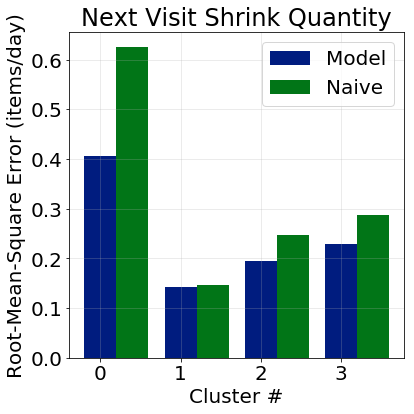

In [128]:
print('Plotting...')
pred_col_mask = (X_train_ss.dtypes == int) | (X_train_ss.dtypes == np.float64) | (X_train_ss.dtypes == np.uint8)
pred_cols = X_train_ss.columns[pred_col_mask]
cluster_rmse, naive_rmse = model_clusters(fitted_models, X_test=X_test_ss, X_test_ns=X_test, naive_col='qty_shrink_per_day_lag1_by_cat', col_mask=pred_cols, y_test=y_test)
plot_rmse(cluster_rmse, naive_rmse, num_clusters=len(X.cluster.unique()), 
  yaxis_units='items/day' ,title='Next Visit Shrink Quantity')

In [111]:
cust_table.groupby('cluster').std()

,qty_shrink_per_day,shrink_value_per_day,POP2010,FD_ratio,unemp_rate,dens_sq_mile,avg_UPC_per_visit,days_between_visits
cluster,,,,,,,,
0,0.117353,0.526605,7.292360e+05,0.094402,0.036429,2906.704300,1.312182,8.681023
1,0.052358,0.207415,3.184685e+06,0.025116,0.025560,21750.184106,1.073273,17.929170
2,0.045090,0.209832,1.151602e+06,0.063057,0.036651,3916.100720,1.054604,16.030386
3,0.038679,0.185159,4.707916e+05,0.070268,0.028702,1710.425539,1.036096,15.477787


In [45]:
X_train.groupby('cluster').count()

,FD_ratio,LAPOP1_10,POP2010,address1,address2,city,creation_date,creation_date_int,customer_id,customer_id_1635139,customer_id_1903139,customer_id_2139,customer_id_2331150,customer_id_2741156,customer_id_2773156,customer_id_2782156,customer_id_2956160,customer_id_2977160,customer_id_3083182,customer_id_3088198,customer_id_3088201,customer_id_3089336,customer_id_3093327,customer_id_3093329,customer_id_3097348,dens_sq_mile,item_UPC,item_category,item_category_10,item_category_16,item_category_19,item_category_26,item_category_31,item_category_38,item_category_41,item_category_43,item_category_44,item_category_46,item_category_58,item_category_62,item_category_77,item_category_79,item_category_8,item_category_90,item_description,item_id,last_edit_date,last_edit_date_int,list_header_id,old_item_UPC,old_item_id,prev_item_move_date,prev_item_move_date_int,prev_visit_date,prev_visit_date_int,qty_POG_limit,qty_prev_end_inventory,qty_sales,qty_shrink_per_day_lag1_by_cat,qty_shrink_per_day_lag2_by_cat,qty_start_inventory,sales_rep_id,sales_rep_id_2,sales_value,ship_id,ship_list_pk,shrink_value_per_day_lag1_by_cat,shrink_value_per_day_lag2_by_cat,state,unemp_rate,unit_price,visit_date,visit_date_int,zip_code
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894,26894
1,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193
2,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234,25234
3,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083,34083


In [73]:
X_test.groupby('cluster').count() / len(X_test)

,FD_ratio,LAPOP1_10,POP2010,address1,address2,city,creation_date,creation_date_int,customer_id,customer_id_1635139,customer_id_1903139,customer_id_2139,customer_id_2331150,customer_id_2741156,customer_id_2773156,customer_id_2782156,customer_id_2956160,customer_id_2977160,customer_id_3083182,customer_id_3088198,customer_id_3088201,customer_id_3089336,customer_id_3093327,customer_id_3093329,customer_id_3097348,dens_sq_mile,item_UPC,item_category,item_category_10,item_category_16,item_category_19,item_category_26,item_category_31,item_category_38,item_category_41,item_category_43,item_category_44,item_category_46,item_category_58,item_category_62,item_category_77,item_category_79,item_category_8,item_category_90,item_description,item_id,last_edit_date,last_edit_date_int,list_header_id,old_item_UPC,old_item_id,prev_item_move_date,prev_item_move_date_int,prev_visit_date,prev_visit_date_int,qty_POG_limit,qty_prev_end_inventory,qty_sales,qty_shrink_per_day_lag1_by_cat,qty_shrink_per_day_lag2_by_cat,sales_rep_id,sales_rep_id_2,sales_value,ship_id,ship_list_pk,shrink_value_per_day_lag1_by_cat,shrink_value_per_day_lag2_by_cat,state,unemp_rate,unit_price,visit_date,visit_date_int,zip_code
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706,0.307706
1,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637,0.013637
2,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715,0.288715
3,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941,0.389941


In [124]:
0.3077 * 40.2 + 0.0136 * 5.2 + 0.2887 * 21.3 + 0.3899 * 20.3

26.504540000000002